# (Traditional) Autoencoder

In [1]:
import torch  
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from typing import List

### Helper Class for logging trainings data

In [2]:
class TrainData():
    '''Helper class that stores informatoion during training'''
    def __init__(self) -> None:
        self.ls_losses:List[float] = []

        '''important for visualization'''
        self.ls_epochs:List[int]    = []
        self.ls_imgs:List[torch.Tensor]  = []
        self.ls_recimgs:List[torch.Tensor]  = [] 
        pass 

### Visualization

In [3]:
import matplotlib.pyplot as plt 

In [4]:
# plot loss per epoch
def plot_losses(losses: List[float]) -> None:
    '''plots loss per epoch'''
    epochs = range(1, len(losses)+1)

    xticks = range(min(epochs), max(epochs)+1) # transforms into integer

    plt.plot(epochs, losses)
    plt.title('Loss per epoch'), plt.ylabel('Loss'),  plt.xlabel('Epoch')
    plt.xticks(xticks)
    plt.legend()
    plt.show()

    return

In [5]:
# plot images vs. recostructed images
def plot_imgs_and_reconimgs(train_data:TrainData) -> None:
    num_epochs = len(train_data.ls_epochs)

    num_imgs_per_row = 9 
    num_rows = 2


    for i_epoch in range(0, num_epochs,4):
        plt.figure(figsize=(9,2))
        plt.gray()
        imgs    =  train_data.ls_imgs[i_epoch].detach().numpy()
        recimgs  = train_data.ls_recimgs[i_epoch].detach().numpy()

        for i, img in enumerate(imgs):
            if i % num_imgs_per_row == 0: break

            plt.subplot(num_rows,num_imgs_per_row, i+1)
            img = img.reshape(-1, 28, 28)
            plt.imshow(img[0])
        
        for i, img in enumerate(recimgs):
            if i % num_imgs_per_row == 0: break

            plt.subplot(num_rows,num_imgs_per_row, i+1+num_imgs_per_row)
            img = img.reshape(-1, 28, 28)
            plt.imshow(img[0])
            

    plt.show()

In [6]:
# HYPERPARAMETER
batch_size =  64
epochs = 10
lr = 0.1

### Data

In [7]:
# DATA LOADER
transforms = transforms.ToTensor()

train_data = datasets.MNIST('data/mnist', train=True, download=True, transform=transforms)
test_data  = datasets.MNIST('data/mnist', train=False, download=True, transform=transforms)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [8]:
# DATA: look at pixels value range (important for activation function in decoder)
imgs, labels = next(iter(train_dataloader))

print( torch.min(imgs)  , torch.max(imgs) )

tensor(0.) tensor(1.)


### Autoencoder classes

In [9]:
class Autoencoder_Linear(nn.Module):
    '''AE using fully connected layers'''
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 48),
            nn.ReLU(),
            nn.Linear(48, 10),
        ) 
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 48),
            nn.ReLU(),
            nn.Linear(48, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        return

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [10]:
class Autoencoder_Conv(nn.Module):
    def __init__(self):
        super().__init__()

        pass 

    def forward(self, x):
        pass 

### Train & Test functions

In [11]:
def train(epochs: int, model: nn.Module, dataloader: DataLoader, optimizer: optim.Optimizer, criterion) -> TrainData:
    n_batches = len(dataloader)
    train_data: TrainData = TrainData()
    
    model.train()
    for i_epoch in range(epochs):
        loss_epoch = 0
        for i_batch, (X,_) in enumerate(dataloader):
            # adjust shahpe of tensor, so that it fits into first layer
            X = X.reshape(-1, 28*28) 

            # pred (encode & decode)
            recon = model(X)

            # loss (how much difference between each pixel)
            loss = criterion(recon, X)
            loss_epoch += loss

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # print
            if i_batch % 250 == 0:
                print(f'Epoch\t{i_epoch+1}/{epochs}\t\tBatch\t{i_batch}/{n_batches}\t({(100. * i_batch / n_batches):.1f}%)\t\tLoss\t{loss:.4f}')
        
        # Save training data per epoch
        train_data.ls_losses.append(loss_epoch / n_batches)
        train_data.ls_imgs.append(X)
        train_data.ls_recimgs.append(recon)
        train_data.ls_epochs.append(i_epoch)


    return train_data


In [12]:
def test(model:nn.Module, dataloader:DataLoader, criterion) -> None:
    model.eval()

    n_batches = len(dataloader)
    loss = 0

    with torch.no_grad():
        for i_batch, (X,_) in enumerate(dataloader):
            X = X.reshape(-1,  28*28)

            # pred 
            recon = model(X)

            # loss
            loss += criterion(recon, X)

        loss = loss / n_batches

    return loss

### Training

In [13]:
model = Autoencoder_Linear()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [14]:
train_data:TrainData = train(epochs, model, train_dataloader, optimizer, criterion)

Epoch	1/10		Batch	0/938	(0.0%)		Loss	0.2315
Epoch	1/10		Batch	250/938	(26.7%)		Loss	0.0580
Epoch	1/10		Batch	500/938	(53.3%)		Loss	0.0502
Epoch	1/10		Batch	750/938	(80.0%)		Loss	0.0490
Epoch	2/10		Batch	0/938	(0.0%)		Loss	0.0464
Epoch	2/10		Batch	250/938	(26.7%)		Loss	0.0430
Epoch	2/10		Batch	500/938	(53.3%)		Loss	0.0431
Epoch	2/10		Batch	750/938	(80.0%)		Loss	0.0430
Epoch	3/10		Batch	0/938	(0.0%)		Loss	0.0433
Epoch	3/10		Batch	250/938	(26.7%)		Loss	0.0425
Epoch	3/10		Batch	500/938	(53.3%)		Loss	0.0419
Epoch	3/10		Batch	750/938	(80.0%)		Loss	0.0396
Epoch	4/10		Batch	0/938	(0.0%)		Loss	0.0422
Epoch	4/10		Batch	250/938	(26.7%)		Loss	0.0408
Epoch	4/10		Batch	500/938	(53.3%)		Loss	0.0413
Epoch	4/10		Batch	750/938	(80.0%)		Loss	0.0417
Epoch	5/10		Batch	0/938	(0.0%)		Loss	0.0408
Epoch	5/10		Batch	250/938	(26.7%)		Loss	0.0396
Epoch	5/10		Batch	500/938	(53.3%)		Loss	0.0350
Epoch	5/10		Batch	750/938	(80.0%)		Loss	0.0359
Epoch	6/10		Batch	0/938	(0.0%)		Loss	0.0388
Epoch	6/10		Batch	250/938	(26.7

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


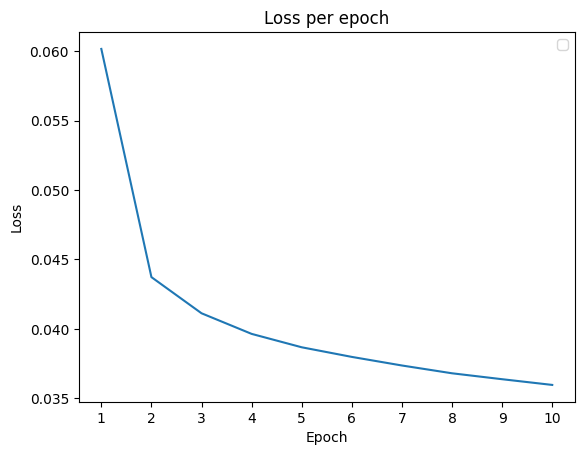

In [15]:
plot_losses(torch.Tensor(train_data.ls_losses))

In [16]:
test(model, test_dataloader,  criterion).item()

0.035791728645563126

### Show generated images

In [17]:
plot_imgs_and_reconimgs(train_data)

<Figure size 900x200 with 0 Axes>

<Figure size 900x200 with 0 Axes>

<Figure size 900x200 with 0 Axes>

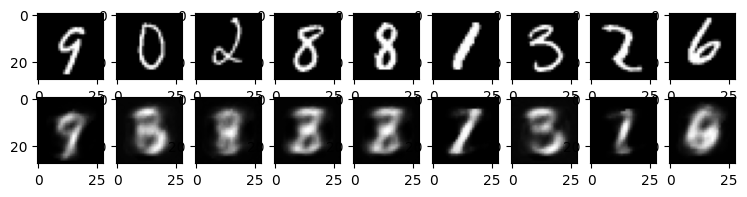

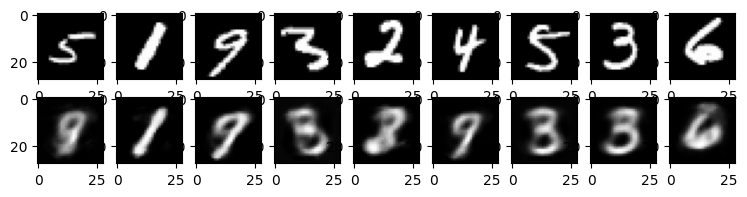

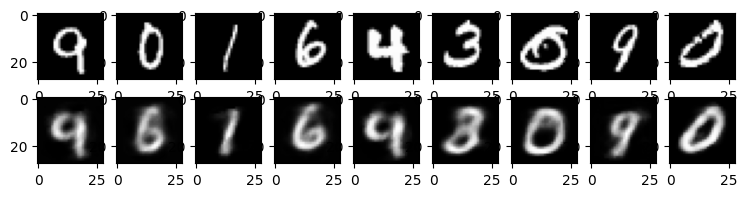

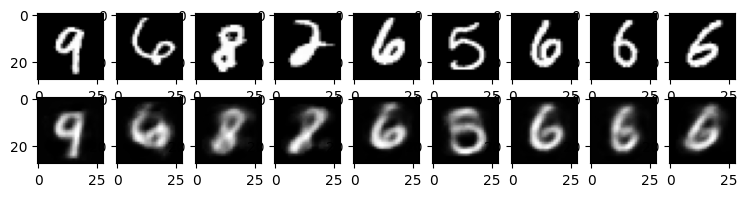

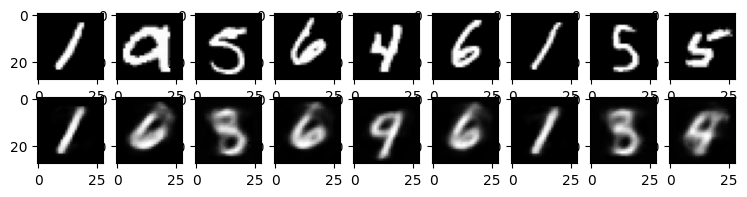

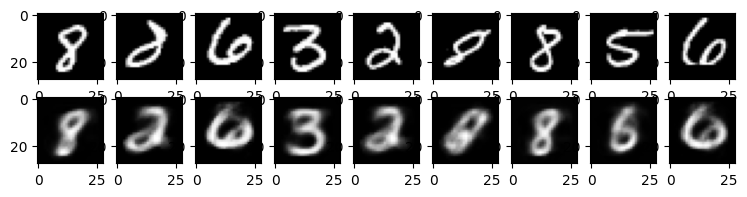

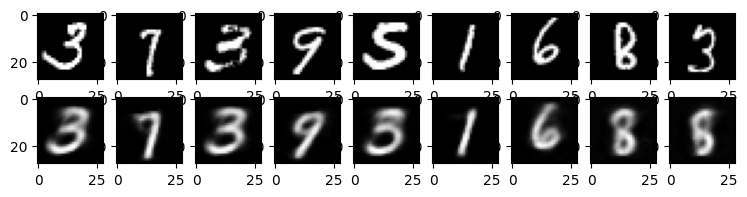

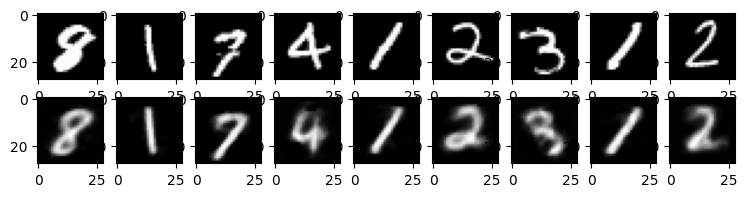

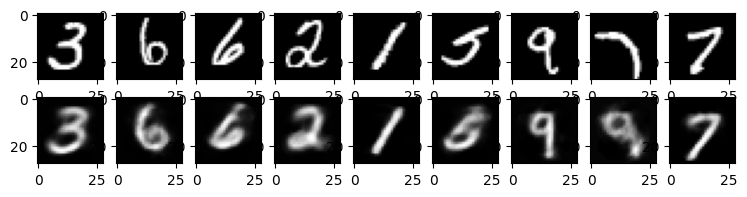

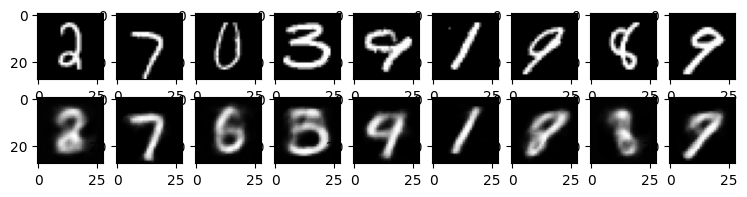

In [18]:
num_epochs = len(train_data.ls_epochs)

num_imgs_per_row = 9 
num_rows = 2


for i_epoch in range(0, num_epochs):
    plt.figure(figsize=(9,2))
    plt.gray()
    imgs    =  train_data.ls_imgs[i_epoch].detach().numpy()
    recimgs  = train_data.ls_recimgs[i_epoch].detach().numpy()

    for i, imgs_batch in enumerate(imgs):
        if i >= num_imgs_per_row : break

        plt.subplot(num_rows,num_imgs_per_row, i+1)
        imgs_batch = imgs_batch.reshape(-1, 28, 28)
        plt.imshow(imgs_batch[0])

    for i, imgs_batch in enumerate(recimgs):
        if i >= num_imgs_per_row : break

        plt.subplot(num_rows,num_imgs_per_row, i+1+num_imgs_per_row)
        imgs_batch = imgs_batch.reshape(-1, 28, 28)
        plt.imshow(imgs_batch[0])

plt.show()         